In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

# Define the list of companies and their corresponding names
company_list = ["AAPL", "GOOGL", "MSFT", "AMZN"]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

# Initialize an empty DataFrame to store the close prices
close_prices_df = pd.DataFrame()

# Loop through each company
for ticker, name in zip(company_list, company_name):
    # Construct the file path
    file_path = os.path.join("../data", "financial", f"{ticker}.csv")
    
    # Read the CSV file and keep only the "close" price
    df = pd.read_csv(file_path, parse_dates=["date"])
    df = df.set_index("date")
    df.rename(columns={"close": name}, inplace=True)
    df.drop(columns=["ticker", "open", "high", "low"], inplace=True)
    
    # Merge with the existing DataFrame
    if close_prices_df.empty:
        close_prices_df = df
    else:
        close_prices_df = close_prices_df.merge(df, how="outer", left_index=True, right_index=True)

# Sort the DataFrame by date
close_prices_df.sort_index(inplace=True)

# Drop rows with NaN values
close_prices_df.dropna(inplace=True)

# Display the resulting DataFrame
print(close_prices_df)


             APPLE  GOOGLE  MICROSOFT  AMAZON
date                                         
2004-08-19    0.55    2.51      27.12    1.93
2004-08-20    0.55    2.71      27.20    1.98
2004-08-23    0.56    2.74      27.24    1.97
2004-08-24    0.57    2.62      27.24    1.95
2004-08-25    0.59    2.65      27.55    2.02
...            ...     ...        ...     ...
2024-03-06  169.12  131.40     402.09  173.51
2024-03-07  169.00  134.38     409.14  176.82
2024-03-08  170.73  135.41     406.22  175.35
2024-03-11  172.75  137.67     404.52  171.96
2024-03-12  173.23  138.50     415.28  175.39

[4924 rows x 4 columns]


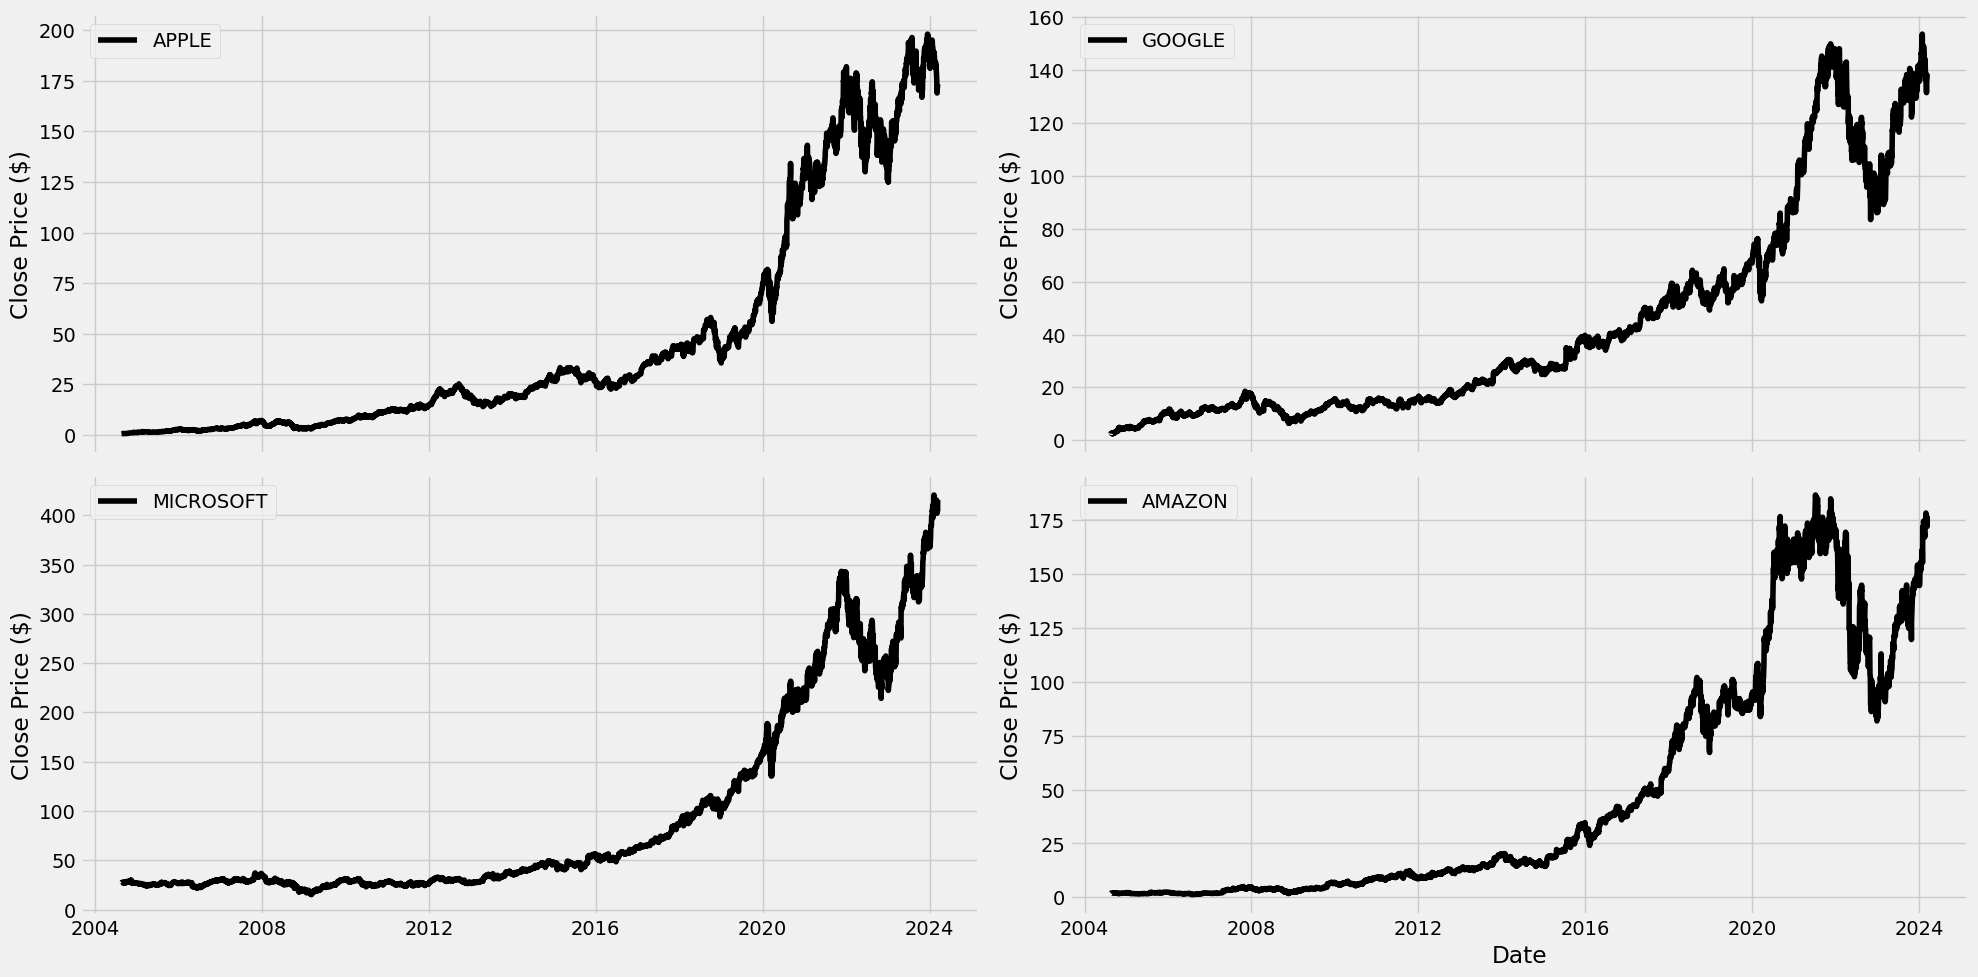

In [2]:
# Plot the time evolution for each column
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=True)

for i, col_name in enumerate(close_prices_df.columns):
    row = i // 2
    col = i % 2
    axs[row, col].plot(close_prices_df.index, close_prices_df[col_name], label=col_name, color='black')
    axs[row, col].set_ylabel('Close Price ($)')
    axs[row, col].legend()

# Set common labels
plt.xlabel('Date')

# Show plot
plt.tight_layout()
plt.show()



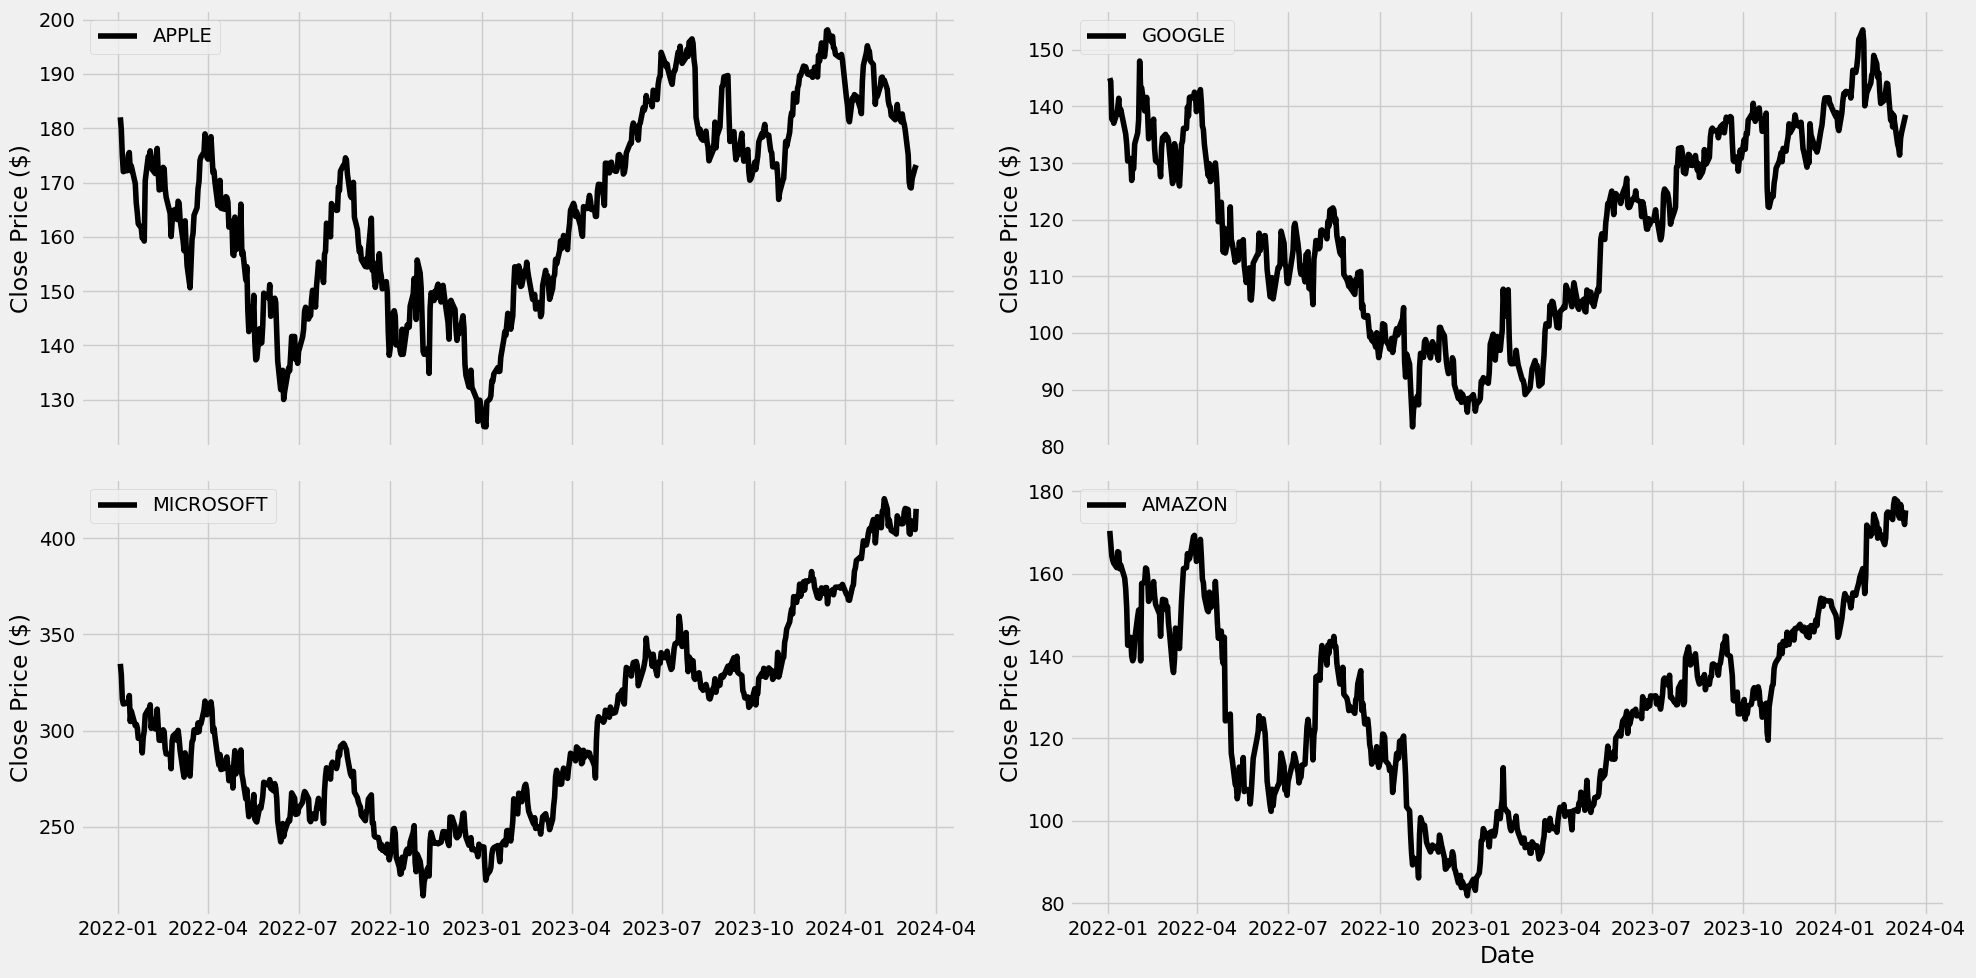

In [3]:
# Filter DataFrame to include only years after 2022
close_prices_df = close_prices_df[close_prices_df.index.year > 2021]

# Plot the time evolution for each column
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=True)

for i, col_name in enumerate(close_prices_df.columns):
    row = i // 2
    col = i % 2
    axs[row, col].plot(close_prices_df.index, close_prices_df[col_name], label=col_name, color='black')
    axs[row, col].set_ylabel('Close Price ($)')
    axs[row, col].legend()

# Set common labels
plt.xlabel('Date')

# Show plot
plt.tight_layout()
plt.show()

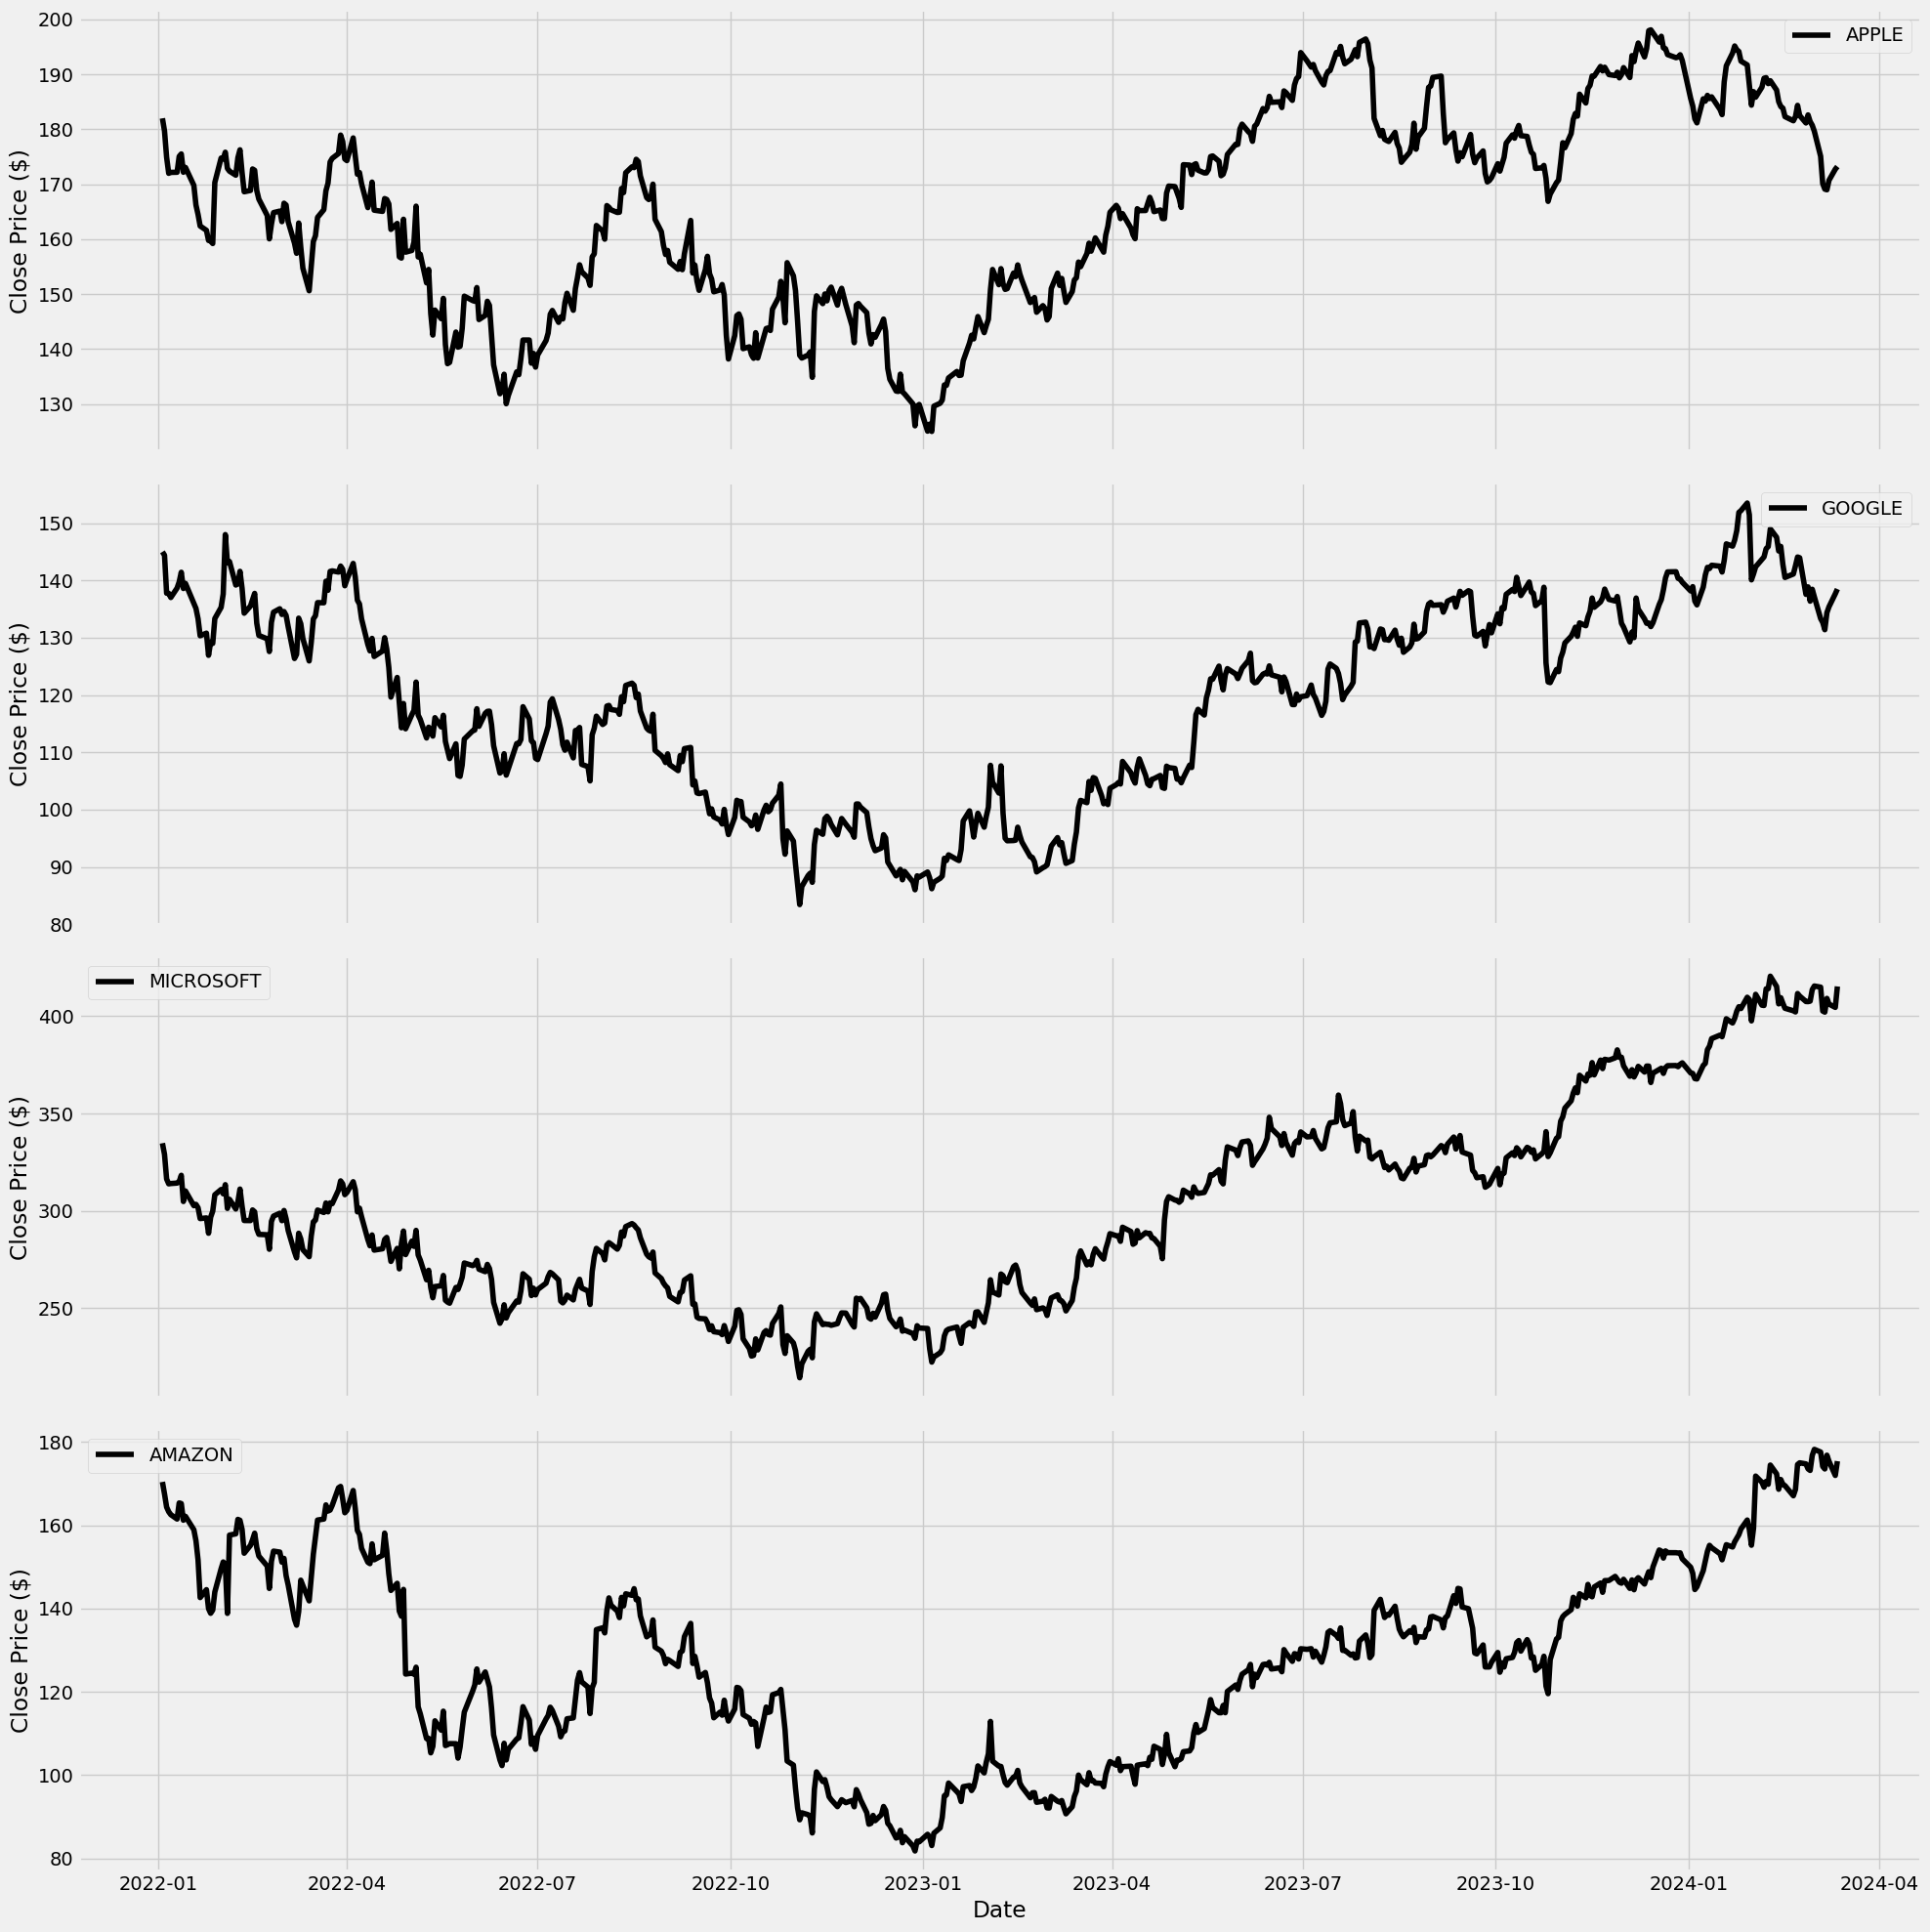

In [4]:
# Plot the time evolution for each column
fig, axs = plt.subplots(4, 1, figsize=(20, 20), sharex=True)

for i, col in enumerate(close_prices_df.columns):
    axs[i].plot(close_prices_df.index, close_prices_df[col], label=col, color='black')
    axs[i].set_ylabel('Close Price ($)')
    axs[i].legend()

# Set common labels
plt.xlabel('Date')

# Show plot
plt.tight_layout()
plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

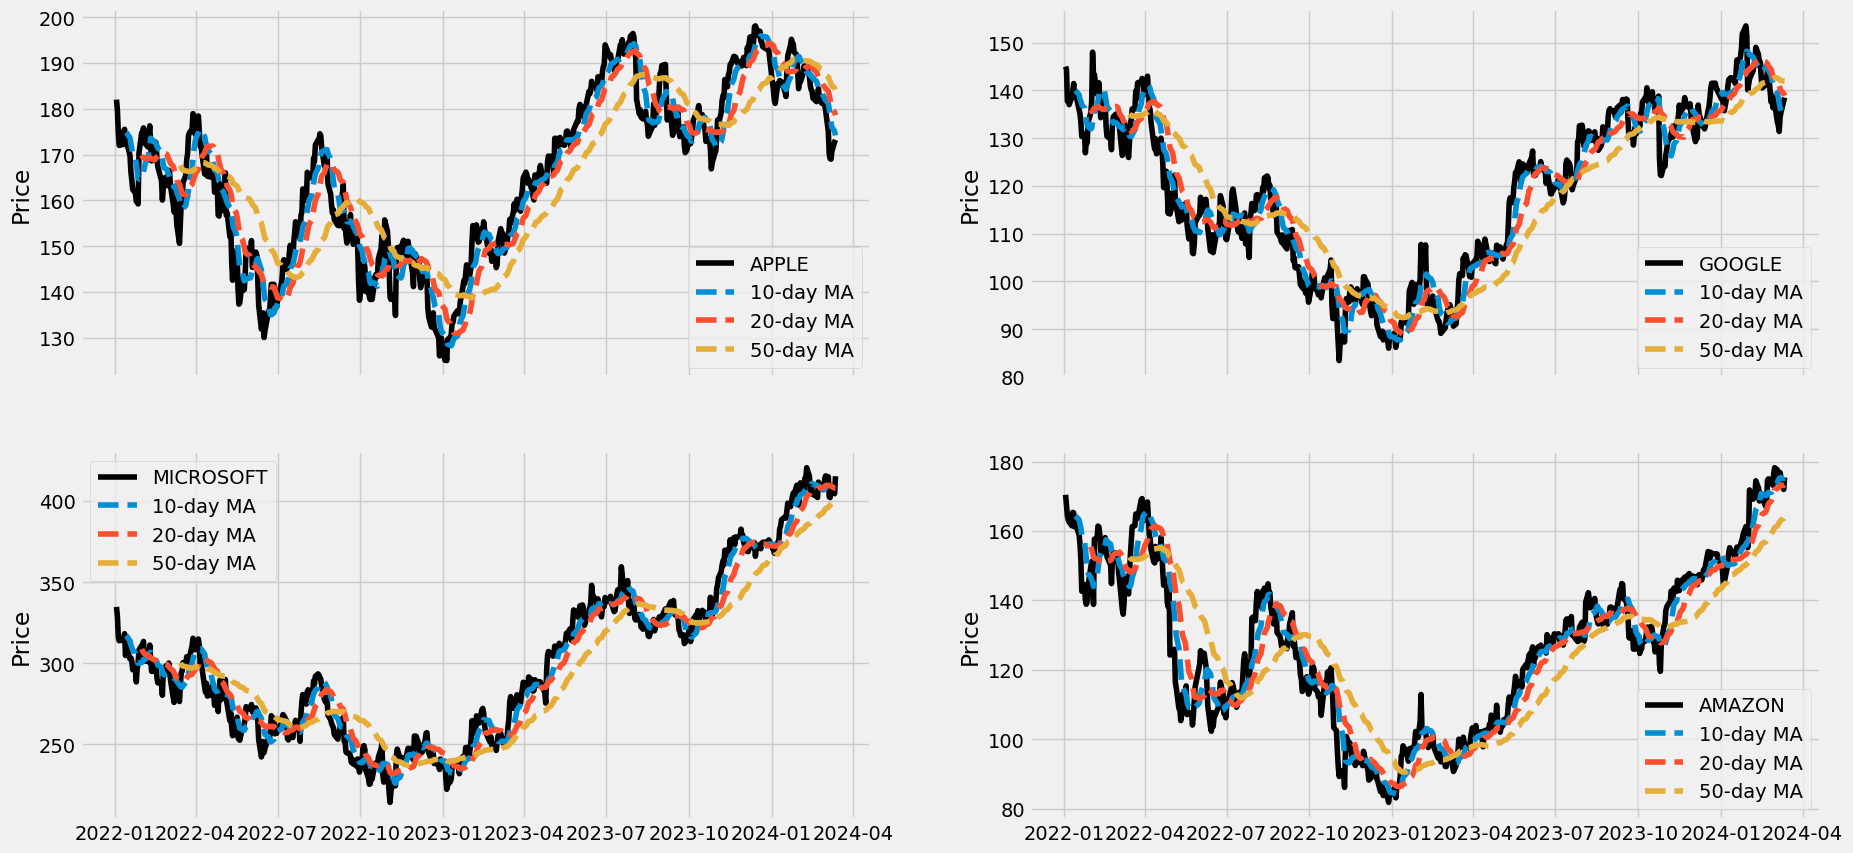

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Filter DataFrame to include only years after 2022
close_prices_df = close_prices_df[close_prices_df.index.year > 2021]

# Calculate moving averages for 10, 20, and 50 days
ma_days = [10, 20, 50]
for ma in ma_days:
    for col_name in close_prices_df.columns:
        ma_col_name = f"{col_name}_MA_{ma}"
        close_prices_df[ma_col_name] = close_prices_df[col_name].rolling(window=ma).mean()

# Plot the time evolution for each column with moving averages
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=True)

for i, col_name in enumerate(close_prices_df.columns):
    row = i // 2
    col = i % 2
    axs[row, col].plot(close_prices_df.index, close_prices_df[col_name], label=col_name, color='black')
    axs[row, col].set_ylabel('Price')
    
    # Plot moving averages
    for ma in ma_days:
        ma_col_name = f"{col_name}_MA_{ma}"
        axs[row, col].plot(close_prices_df.index, close_prices_df[ma_col_name], label=f'{ma}-day MA', linestyle='--')
    
    axs[row, col].legend()

# Set common labels
plt.xlabel('Date')

# Show plot
plt.tight_layout()
plt.show()
